In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'Validated'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True)

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 153
The number of rows (Samples): 943018, The number of columns: 20, number of unique sender id's: (153,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
473986,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.00,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473985,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.00,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473984,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.00,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473983,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.00,ETH,0x0000000000000000000000000000000000000000,NaN,275.987191,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473982,0xa7f48ef0dac09e9e4174467c2b0e464a9b89707a2eec...,NaN,2016-08-03 12:21:39+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.00,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473981,0x73b037de4db4029320e5a37b3e1ba5656ba158de21df...,NaN,2017-03-01 17:30:35+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x6012ad30aa2c75976ee74f704c991c682ef62200,NaN,0.32,ETH,0x0000000000000000000000000000000000000000,NaN,5.493770,1.400000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473980,0x9a6712f22c005342c704ec2a0b8ec6cf2398c8434fe4...,NaN,2017-03-13 11:52:21+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,0.20,ETH,0x0000000000000000000000000000000000000000,NaN,5.689213,7.000000e-09,121000.0,21000,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473979,0x75272367770177cf7e2b519524357565efecf2f2fcbd...,NaN,2017-03-13 11:55:47+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,10.00,ETH,0x0000000000000000000000000000000000000000,NaN,284.460652,7.000000e-09,121000.0,21000,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473978,0x56e1a365651e0589c2848ab700652cd6b98ad4aa5133...,NaN,2017-03-13 11:59:45+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,99.70,ETH,0x0000000000000000000000000000000000000000,NaN,2836.072700,7.000000e-09,121000.0,21000,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
473977,0xcd72283625e97a7af140d874874daf3993194bd648e3...,NaN,2017-03-13 12:07:41+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x006c3b72c45f680af995dd9b8777bc21eddcc779,NaN,500.00,ETH,0x0000000000000000000000000000000000000000,NaN,14223.032600,7.000000e-09,121000.0,21000,NaN,NaN,NaN,0,NaN,FakeHack137001.csv


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
474047,0xb62750f111dae6172a96b1632a31dc857b7791e4450a...,NaN,2017-09-04 14:09:46+00:00,0x3d51bbefcce4ecbc5472b601ca9e99a3ae9bc93a,0xfbf6f29c126382cf15795bb209ee506a174cc709,NaN,4.000000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,11988.69328,2.720000e-08,25201.0,21000,NaN,NaN,NaN,1,NaN,FakeHeroTokenSale001.csv
474735,0x45f016857e875da7c9b6ac759bad065ec509ca66a7de...,NaN,2017-09-04 15:37:37+00:00,0x8da0a15786008f543a760701e2021f992e1c1cc5,0xfbf6f29c126382cf15795bb209ee506a174cc709,NaN,4.000000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,11988.69328,5.000000e-08,200000.0,21000,NaN,NaN,NaN,1,NaN,FakeHeroTokenSale002.csv
473947,0x4f1fc1139f31c15d4419c9764ab0f2f08b12697f8d6b...,NaN,2017-09-04 22:56:03+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0x4073aa0f9885bbe59895a27158bbe865052678b8,NaN,7.499956e+01,ETH,0x0000000000000000000000000000000000000000,NaN,23922.81964,2.100000e-08,21000.0,21000,NaN,NaN,NaN,1,NaN,FakeHack137001.csv
479083,0x759c8b6d78d3a7c7ef08abb6a3a3ec9038154f773da4...,NaN,2017-09-05 02:27:09+00:00,0xd648b0d5f8fc7920ac78e5ef214e56f88c30576f,0xfbf6f29c126382cf15795bb209ee506a174cc709,NaN,1.000000e+02,ETH,0x0000000000000000000000000000000000000000,NaN,31897.28041,2.100000e-08,21000.0,21000,NaN,NaN,NaN,1,NaN,FakeHeroTokenSale003.csv
479140,0x51131208a4f9c57e12ca9401ae5f28017b15895a6a0a...,NaN,2017-09-05 02:40:32+00:00,0x761084ffd1c929a31fee582a6d02c4f31494fb17,0xfbf6f29c126382cf15795bb209ee506a174cc709,NaN,1.000000e+02,ETH,0x0000000000000000000000000000000000000000,NaN,31897.28041,2.100000e-08,200000.0,21000,NaN,NaN,NaN,1,NaN,FakeHeroTokenSale004.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915073,0x9d349d3742ad50a41a3c3769d6319eebfd8b82c8b0d7...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.031957e+03,AXS,0xbb0e17ef65f82ab018d8edd776e8dd940327b28b,erc20,12735.54533,7.920000e-09,800000.0,71657,NaN,NaN,NaN,1,NaN,Wintermute001.csv
915072,0xfee84987420e1da4a50bfc41a823a97b9d8bf6419b75...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.104207e+05,OGN,0x8207c1ffc5b6804f6024322ccf34f29c3541ae26,erc20,15801.87719,7.920000e-09,800000.0,77912,NaN,NaN,NaN,1,NaN,Wintermute001.csv
915071,0x667559ba29645a6115c81ebcd09fddc571c6b97f479d...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,3.955927e+04,ENJ,0xf629cbd94d3791c9250152bd8dfbdf380e2a3b9c,erc20,19033.77573,7.920000e-09,800000.0,72924,NaN,NaN,NaN,1,NaN,Wintermute001.csv
915070,0x5caa93f7398277f2aef8d30495150a8a8370f01a1785...,NaN,2022-09-20 05:46:59+00:00,0x00000000ae347930bd1e7b0f35588b92280f9e75,0x0248f752802b2cfb4373cc0c3bc3964429385c26,NaN,1.425870e+04,API3,0x0b38210ea11411557c13457d4da7dc6ea731b88a,erc20,21137.94696,7.920000e-09,800000.0,74723,NaN,NaN,NaN,1,NaN,Wintermute001.csv


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    940814
1      2204
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

153

In [13]:
dfData['Label'].value_counts()

0    940814
1      2204
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943018 entries, 473986 to 632497
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    943018 non-null  object             
 1   Transaction Time  0 non-null       float64            
 2   Block Time        943018 non-null  datetime64[ns, UTC]
 3   Sender ID         943018 non-null  object             
 4   Receiver ID       943018 non-null  object             
 5   Receiver Type     855530 non-null  object             
 6   Amount            943018 non-null  float64            
 7   Currency          942740 non-null  object             
 8   Currency Hash     920340 non-null  object             
 9   Currency Type     643452 non-null  object             
 10  Amount [USD]      838645 non-null  float64            
 11  Gas Price         943018 non-null  float64            
 12  Gas Limit         943018 non-null  floa

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,9.430180e+05,8.386450e+05,9.430180e+05,9.430180e+05,9.430180e+05,0.0,0.0,0.0,943018.000000,0.0
mean,NaN,4.151690e+21,7.802356e+04,7.966018e-08,5.417405e+05,1.993283e+05,NaN,NaN,NaN,0.002337,NaN
std,NaN,2.839815e+24,1.744204e+06,1.099798e-07,1.412484e+06,4.494141e+05,NaN,NaN,NaN,0.048288,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000,NaN
25%,NaN,3.770015e-01,1.217418e+02,2.600000e-08,9.000000e+04,4.503800e+04,NaN,NaN,NaN,0.000000,NaN
50%,NaN,4.731389e+01,1.001670e+03,5.497926e-08,2.158870e+05,1.049950e+05,NaN,NaN,NaN,0.000000,NaN
75%,NaN,5.115325e+03,7.891840e+03,1.000000e-07,3.859640e+05,2.236230e+05,NaN,NaN,NaN,0.000000,NaN
max,NaN,1.950000e+27,5.253215e+08,2.192162e-05,3.005662e+07,2.577378e+07,NaN,NaN,NaN,1.000000,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 125703


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 817315, The number of columns: 20


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817315 entries, 473986 to 632497
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    817315 non-null  object             
 1   Transaction Time  0 non-null       float64            
 2   Block Time        817315 non-null  datetime64[ns, UTC]
 3   Sender ID         817315 non-null  object             
 4   Receiver ID       817315 non-null  object             
 5   Receiver Type     742463 non-null  object             
 6   Amount            817315 non-null  float64            
 7   Currency          817132 non-null  object             
 8   Currency Hash     794637 non-null  object             
 9   Currency Type     518173 non-null  object             
 10  Amount [USD]      817315 non-null  float64            
 11  Gas Price         817315 non-null  float64            
 12  Gas Limit         817315 non-null  floa

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,8.173150e+05,8.173150e+05,8.173150e+05,8.173150e+05,8.173150e+05,0.0,0.0,0.0,817315.000000,0.0
mean,NaN,4.771722e+21,8.005979e+04,8.088016e-08,3.373314e+05,1.815415e+05,NaN,NaN,NaN,0.002438,NaN
std,NaN,3.050385e+24,1.766771e+06,1.128487e-07,7.194201e+05,4.276986e+05,NaN,NaN,NaN,0.049321,NaN
min,NaN,0.000000e+00,3.580000e-34,0.000000e+00,2.100000e+04,1.920000e+04,NaN,NaN,NaN,0.000000,NaN
25%,NaN,2.579000e-01,1.500565e+02,2.600000e-08,9.000000e+04,4.071400e+04,NaN,NaN,NaN,0.000000,NaN
50%,NaN,1.102000e+01,1.079064e+03,5.581741e-08,2.121740e+05,1.017340e+05,NaN,NaN,NaN,0.000000,NaN
75%,NaN,3.490645e+03,8.412198e+03,1.007957e-07,3.560810e+05,2.116790e+05,NaN,NaN,NaN,0.000000,NaN
max,NaN,1.950000e+27,5.253215e+08,2.192162e-05,3.005662e+07,2.577378e+07,NaN,NaN,NaN,1.000000,NaN


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 100 Attackers
0xa14d5da3c6bf2d9304fe6d4bc6942395b4de048b    297
0xeb31973e0febf3e3d7058234a5ebbae1ab4b8c23    292
0x5578840aae68682a9779623fa9e8714802b59946    121
0xb3df999c5dc026dea265aeb02b8519844c9b6d5e    111
0x0248f752802b2cfb4373cc0c3bc3964429385c26    109
                                             ... 
0x601a1dd67a637fc3ff0141724152e15abe1905f7      1
0xb70f65c1faa2f1160d006b585ebf564781e8dae6      1
0x4073aa0f9885bbe59895a27158bbe865052678b8      1
0xebc6bd6ac2c9ad4adf4ba57e9f709b8b9cf03c40      1
0xf443d4df8bc1361ec1f37dd34fd1debe10f3e345      1
Name: Receiver ID, Length: 100, dtype: int64


Text(0, 0.5, 'Number of Attackers')

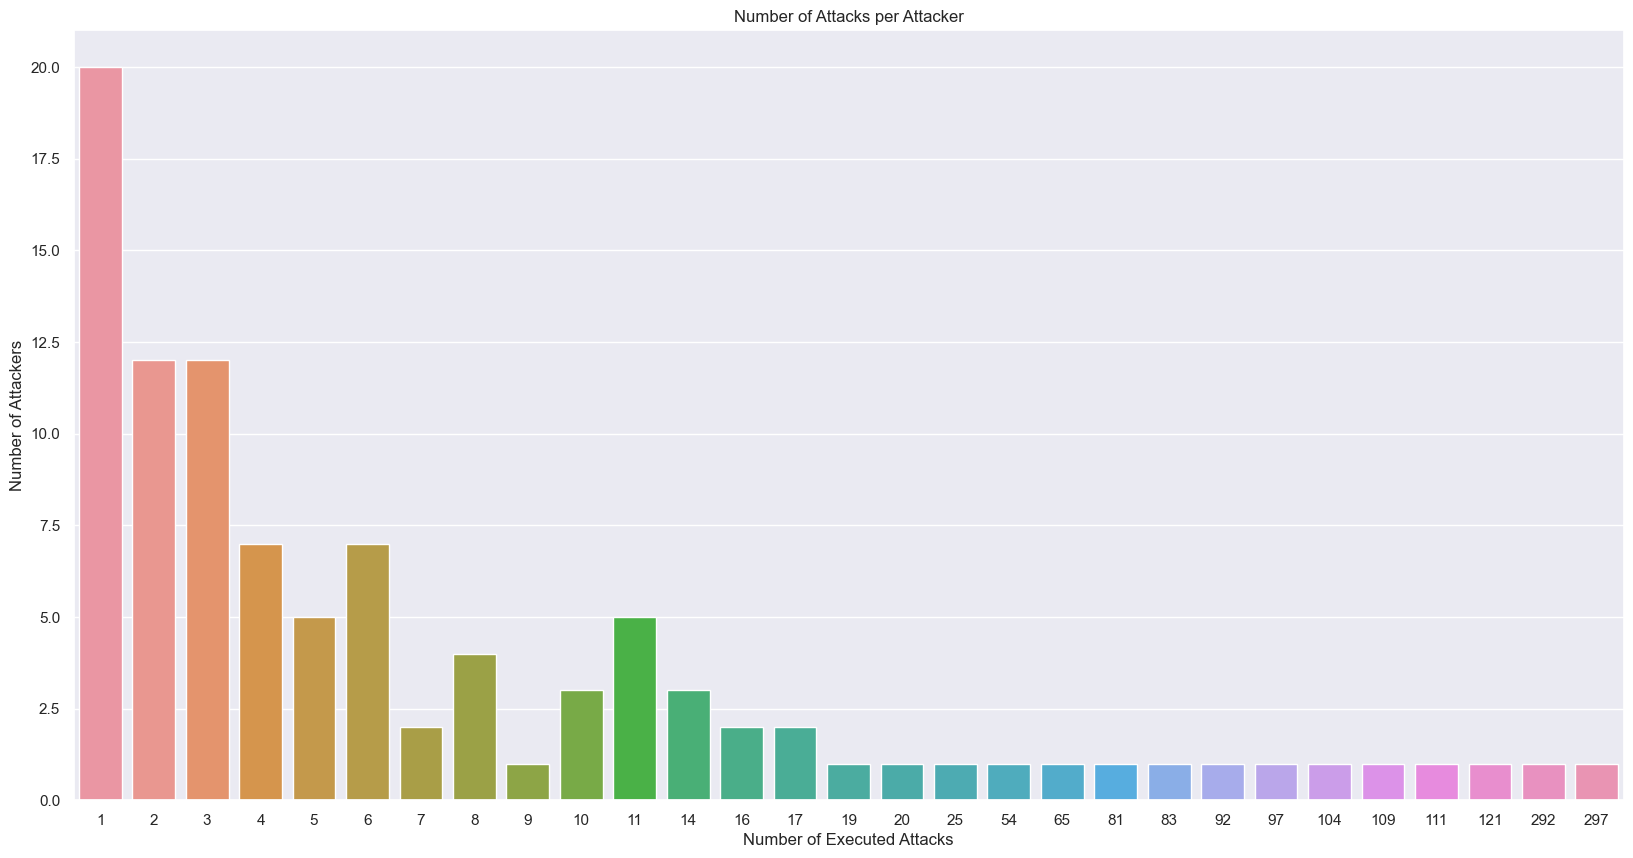

In [24]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [25]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

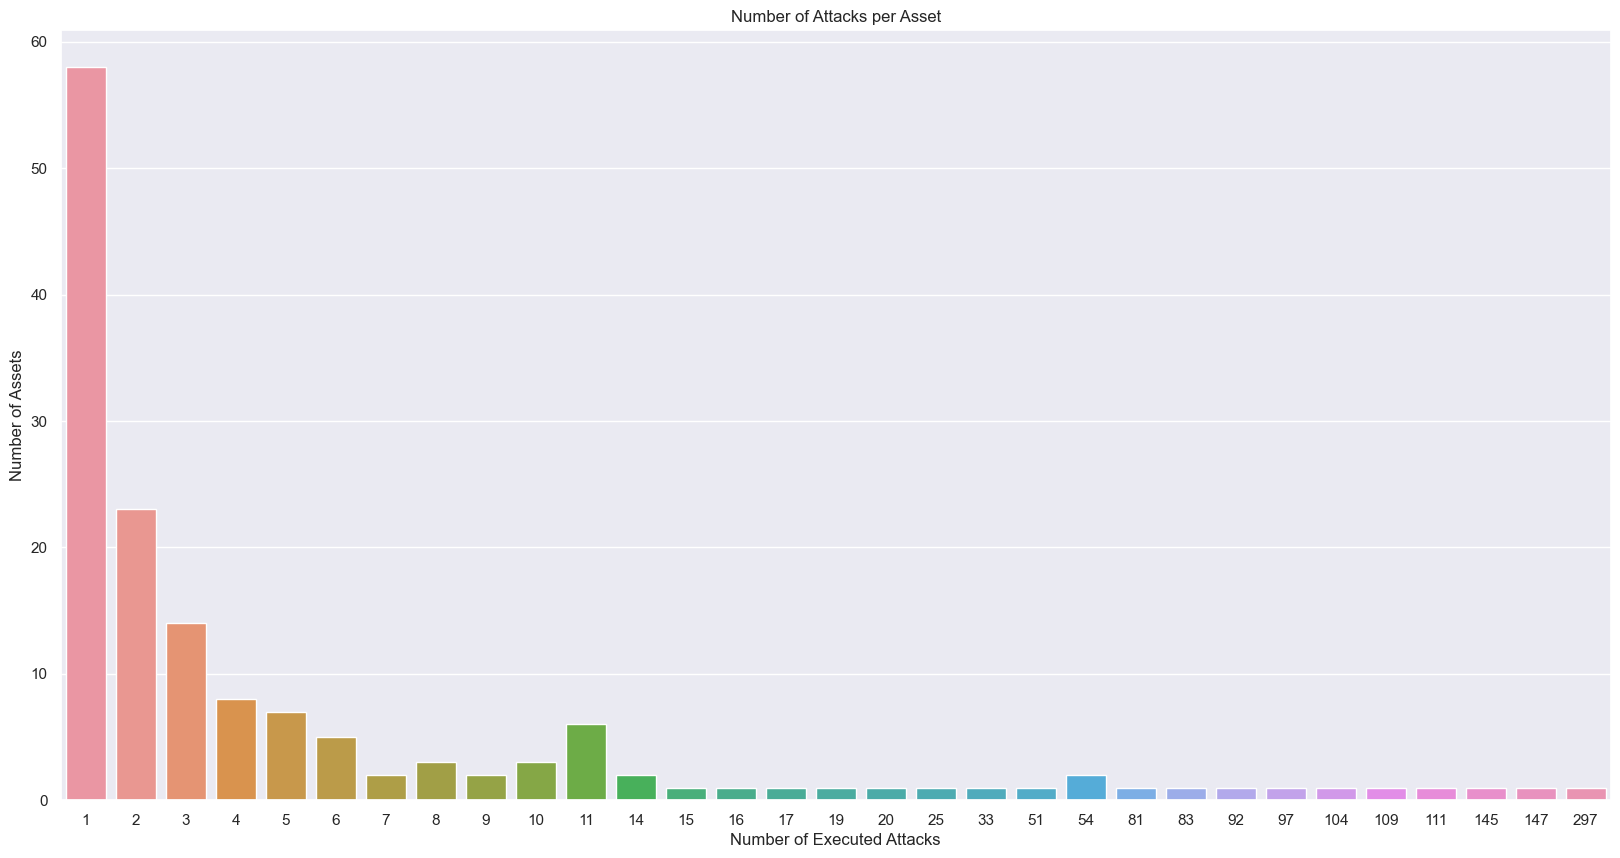

In [26]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [27]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x0248f752802b2cfb4373cc0c3bc3964429385c26,0x00000000ae347930bd1e7b0f35588b92280f9e75,109
1,0x03d1d0e4061152c6a698309aaa4968aae58585a8,0x2f2ca827b3c2c57d554d08698e10c3d8016e9f81,1
2,0x05605a807f4444f8c2fdbc44f51717ab6c055cd2,0x6fb209016b489977ecc78abf3eb5a8613e7ac728,4
3,0x07e02088d68229300ae503395c6536f09179dc3e,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,3
4,0x098b716b8aaf21512996dc57eb0615e2383e2f96,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,3
5,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,0xc36442b4a4522e871399cd717abdd847ab11fe88,8
6,0x0ae1554860e51844b61ae20823ef1268c3949f7c,0x7ea2be2df7ba6e54b1a9c70676f668455e329d29,1
7,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x478c070341265d5fc563512ad7c9c6481a4a3a24,1
8,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x785038e55c3c77256bdc9a03535fd3e8d948a116,1
9,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x87654f58faff71f04291b293e4af2d52dcbe7f15,1


In [28]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [29]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

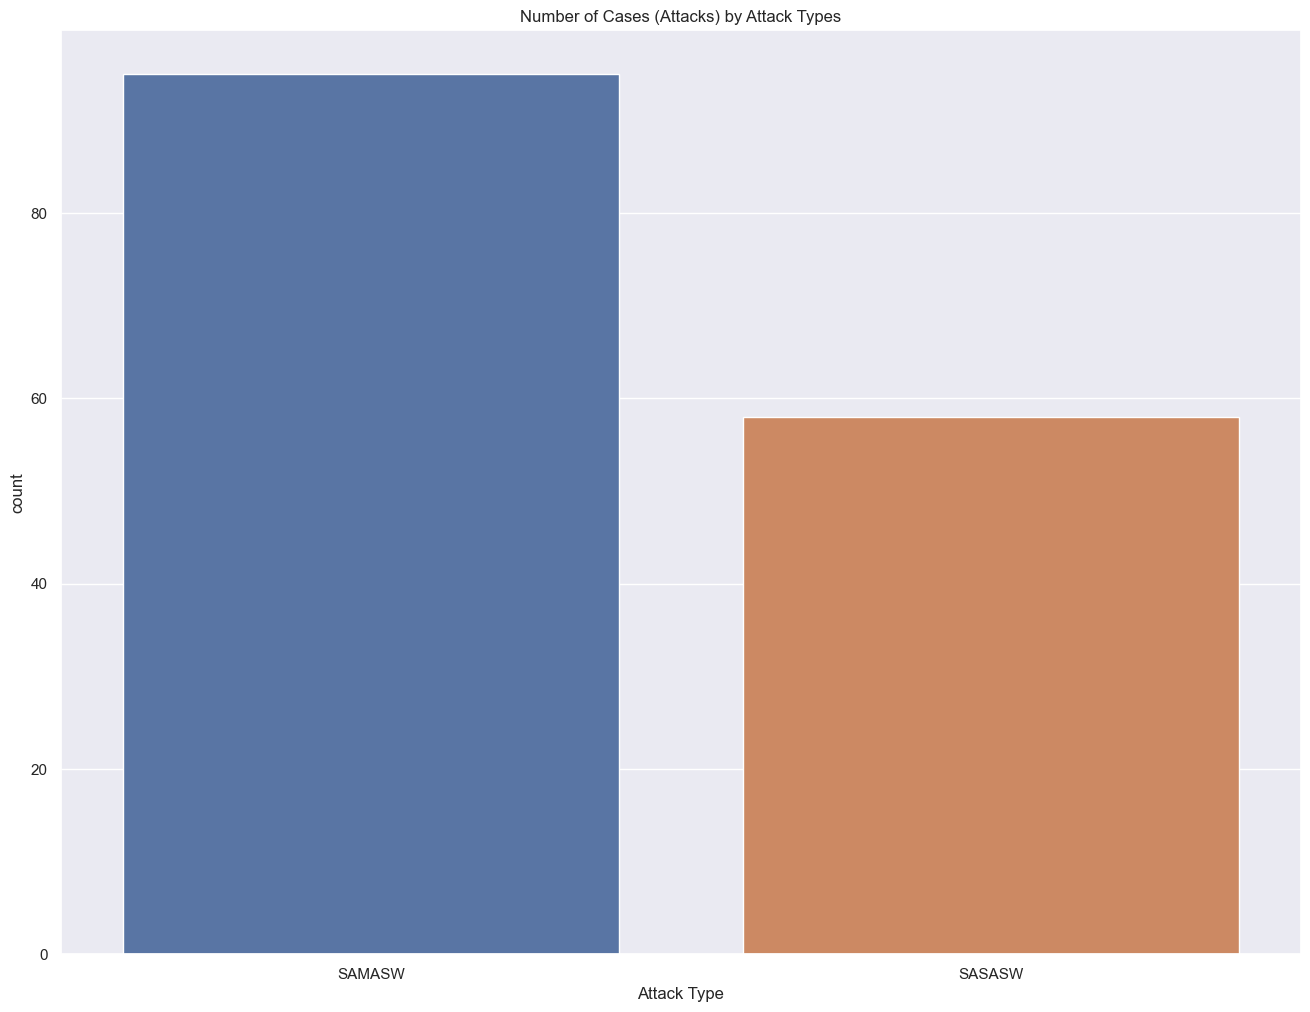

In [30]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [31]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [32]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [33]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [34]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [35]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [36]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [37]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [38]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [39]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [40]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [41]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Visualization

## Features Pre Processing (For Training Phase)

In [42]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

### K-fold training, using categorical variables (EXPERIMENT)

In [43]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [44]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [45]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


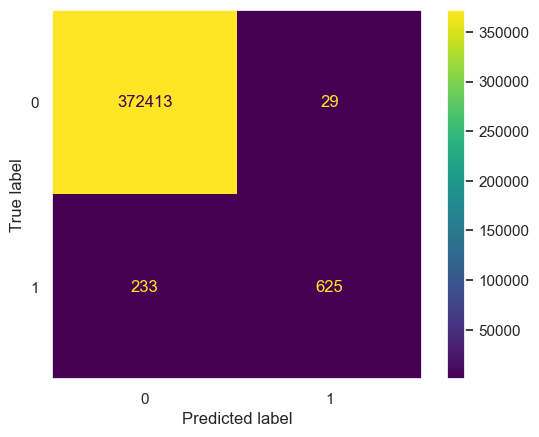

Accuracy         0.999298
F1               0.826720
Precision        0.955657
Recall           0.728438
ROC AUC Score    0.864180
dtype: float64


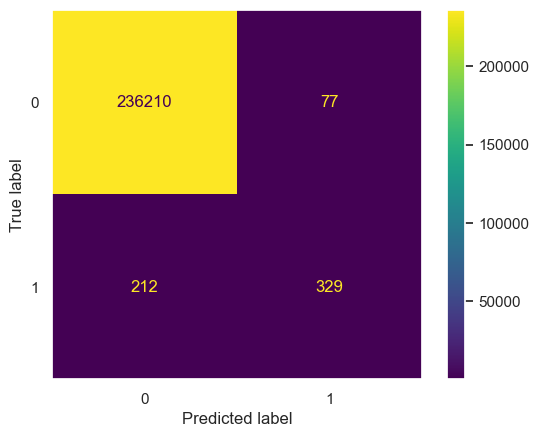

Accuracy         0.998780
F1               0.694826
Precision        0.810345
Recall           0.608133
ROC AUC Score    0.803904
dtype: float64


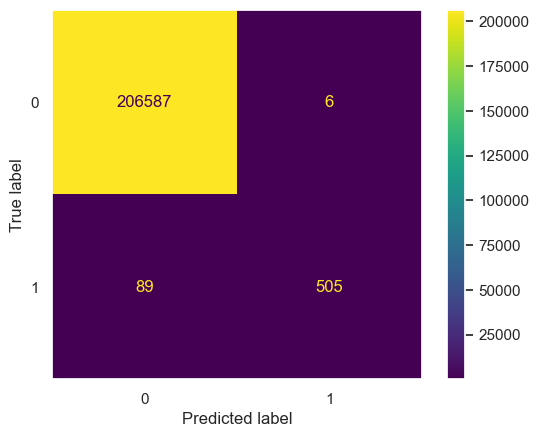

Accuracy         0.999541
F1               0.914027
Precision        0.988258
Recall           0.850168
ROC AUC Score    0.925070
dtype: float64


In [46]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

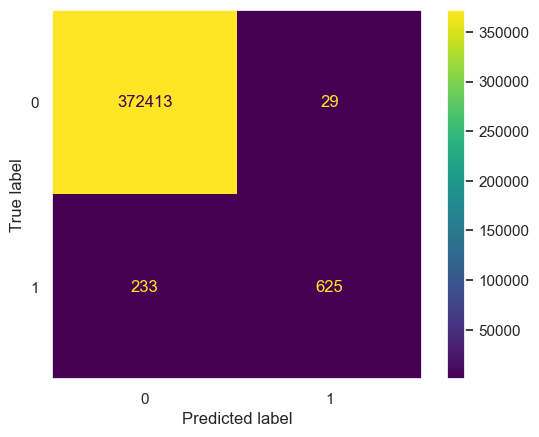

Accuracy         0.999298
F1               0.826720
Precision        0.955657
Recall           0.728438
ROC AUC Score    0.864180
dtype: float64


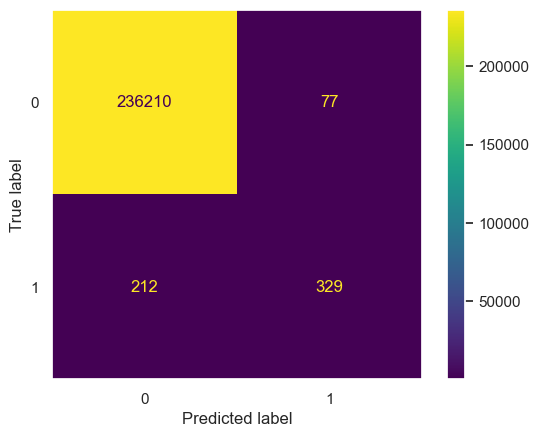

Accuracy         0.998780
F1               0.694826
Precision        0.810345
Recall           0.608133
ROC AUC Score    0.803904
dtype: float64


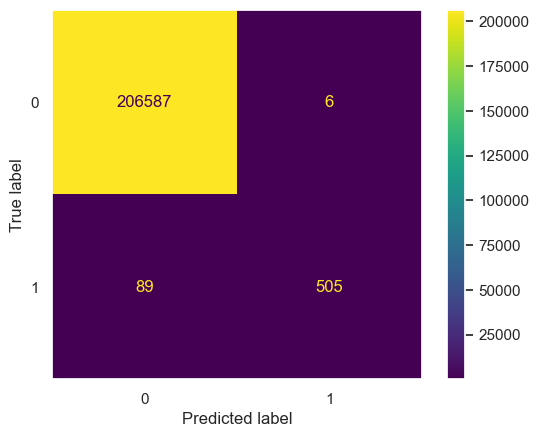

Accuracy         0.999541
F1               0.914027
Precision        0.988258
Recall           0.850168
ROC AUC Score    0.925070
dtype: float64


In [47]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx, vTestIdx, xgbModel])

In [80]:
mX.columns

Index(['Amount', 'Amount USD', 'Gas Price', 'Gas Limit', 'Gas Used',
       'AMOUNT_SUM_ASSET', 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_ASSET',
       'AMOUNT_MEAN_USR', 'AMOUNT_STD_ASSET', 'AMOUNT_STD_USR',
       'AMOUNT_VAR_ASSET', 'AMOUNT_VAR_USR', 'AMOUNT_MEDIAN_ASSET',
       'AMOUNT_MEDIAN_USR', 'AMOUNT_MIN_ASSET', 'AMOUNT_MIN_USR',
       'AMOUNT_MAX_ASSET', 'AMOUNT_MAX_USR', 'TIME_DIFF_MEAN_ASSET',
       'TIME_DIFF_MEAN_USR', 'TIME_DIFF_STD_ASSET', 'TIME_DIFF_STD_USR',
       'TIME_DIFF_MEDIAN_ASSET', 'TIME_DIFF_MEDIAN_USR', 'TIME_DIFF_MIN_ASSET',
       'TIME_DIFF_MIN_USR', 'TIME_DIFF_MAX_ASSET', 'TIME_DIFF_MAX_USR',
       'COIN_TYPE_COUNT_ASSET', 'COIN_TYPE_COUNT_USR_MEAN_ASSET',
       'COIN_TYPE_USR_MEAN_ASSET_RATIO', 'COIN_TYPE_COUNT_USR',
       'RECEIVER_TYPE_COUNT_ASSET', 'RECEIVER_TYPE_COUNT_USR', 'TIME_HOUR',
       'TIME_WEEKDAY', 'TIME_INTERVL_USR', 'AMOUNT_STD_RATIO_USR_ASSET',
       'AMOUNT_MEAN_RATIO_USR_ASSET', 'TIME_DIFF_STD_RATIO_USR_ASSET',
       'TIME_DIFF_MEAN_

In [91]:
dfData_.iloc[models[0][0]].shape , dfData_.iloc[models[0][1]].shape 


((444015, 99), (373300, 99))

In [92]:
dfData_.iloc[models[0][0]]['File Name'].unique().shape , dfData_.iloc[models[0][1]]['File Name'].unique().shape
#.shape , dfData_.iloc[models[-1][1]].shape

((80,), (73,))

In [93]:
d1 = dfData_.iloc[models[0][0]] 
d2 = dfData_.iloc[models[0][1]] 
d1[d1['Label'] == 0].shape , d1[d1['Label'] == 1].shape , d2[d2['Label'] == 0].shape , d2[d2['Label'] == 1].shape

((442880, 99), (1135, 99), (372442, 99), (858, 99))

In [69]:
dfData_['Attack_Type'] =  dfData_.apply(lambda x: dat[x['File Name']] if x['File Name'] in dat else 'not found',axis=1)

In [71]:
dfData_['Attack_Type'].iloc[models[-1][1]].value_counts()

Exploit              141207
Private Key           25118
Access control        21032
Phishing              18762
Exit Scam               950
Flash Loan Attack       118
Name: Attack_Type, dtype: int64

In [63]:
dd = pd.read_csv('a_t.csv' , index_col=False)
dd = dd.reset_index(drop=True)
dd['Attack Name'] = dd['Attack Name'] + '.csv'	
	
dat = dd.set_index('Attack Name').to_dict()['Exploit Type']  
dat

{'0xhabitat001.csv': 'Phishing',
 'AnibusDAO001.csv': 'Phishing',
 'AnySwap001.csv': 'Access control',
 'BadgerDAO001.csv': 'Exploit',
 'BadgerDAO002.csv': 'Exploit',
 'Bitmart001.csv': 'Exploit',
 'BrincFinance001.csv': 'Exploit',
 'BrincFinance002.csv': 'Exploit',
 'bZx001.csv': 'Access control',
 'ChainSwap001.csv': 'Exploit',
 'ChainSwap002.csv': 'Exploit',
 'ChainSwap003.csv': 'Exploit',
 'ChainSwap004.csv': 'Exploit',
 'ChainSwap005.csv': 'Exploit',
 'ChainSwap006.csv': 'Exploit',
 'CoverProtocol001.csv': 'Exploit',
 'DAOMaker2003.csv': 'Exploit',
 'DAOMaker2004.csv': 'Exploit',
 'HarvestFinance001.csv': 'Flash Loan Attack',
 'IndexFinance001.csv': 'Price Manipulation',
 'InverseFinance001.csv': 'Price Manipulation',
 'Poly_Network001.csv': 'Exploit',
 'Ronin001.csv': 'Exploit',
 'SushiSwap001.csv': 'Exploit',
 'Wormhole001.csv': 'Exploit',
 'Akropolis001.csv': 'Flash Loan Attack',
 'BentFinance001.csv': 'Exploit',
 'Bilaxy001.csv': 'Access control',
 'Coinbene001.csv': 'Exploit'

([<matplotlib.patches.Wedge at 0x1ad4002f550>,
 [Text(0.24892922871617562, 1.0714635967174853, 'Exploit'),
  Text(-1.0641638685207573, -0.2784874520242096, 'Exit Scam'),
  Text(-0.36207098096506257, -1.038703328551034, 'Access control'),
  Text(0.15738757473472023, -1.0886823004527644, 'Private Key'),
  Text(0.5898939821664301, -0.9284530627898385, 'Rugpull'),
  Text(0.9124494673545783, -0.6143581769003701, 'Bank Run'),
  Text(1.0566041192419662, -0.3059211257839332, 'Price Manipulation'),
  Text(1.0931950654701552, -0.12216607070583617, 'Phishing'),
  Text(1.0995536918894855, -0.03133175150231028, 'Abandoned'),
  Text(1.099992696608662, -0.004008417094640905, 'Flash Loan Attack')],
 [Text(0.13577957929973214, 0.5844346891186283, '159525'),
  Text(-0.5804530191931403, -0.15190224655865975, '84664'),
  Text(-0.19749326234457956, -0.5665654519369276, '31717'),
  Text(0.08584776803712012, -0.5938267093378714, '25198'),
  Text(0.3217603539089618, -0.5064289433399118, '24998'),
  Text(0.497

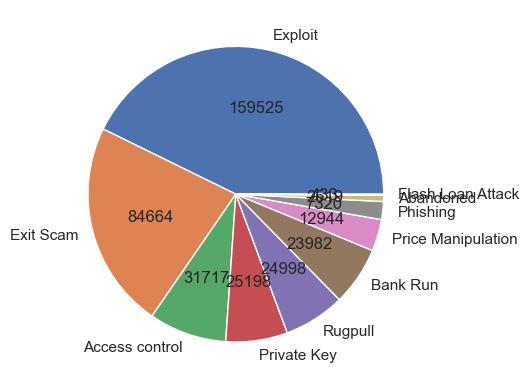

In [96]:
data = dfData_['Attack_Type'].iloc[models[0][1]].value_counts().to_dict()
 
 



def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(data.values(), labels = data.keys(), autopct = autopct_format(data.values()))

([<matplotlib.patches.Wedge at 0x1ad3ffa5f90>,
 [Text(0.6037272824172428, 0.9195180087769304, 'Exit Scam'),
  Text(-0.8185142862615407, 0.7348703036493996, 'Phishing'),
  Text(-0.8493723119777964, -0.6989754470977454, 'Exploit'),
  Text(0.2579403889795512, -1.069330049953277, 'Access control'),
  Text(0.5636084279451794, -0.9446404289194718, 'Flash Loan Attack'),
  Text(0.7861406210326513, -0.7694042656252937, 'Abandoned'),
  Text(0.9063152215851504, -0.6233720551348608, 'Price Manipulation'),
  Text(1.0354489980745483, -0.37127533231607857, 'Private Key'),
  Text(1.0908450321358856, -0.14162314734696058, 'Bank Run'),
  Text(1.0989815199813633, -0.04732461029372095, 'Rugpull')],
 [Text(0.3293057904094051, 0.5015552775146892, '23'),
  Text(-0.4464623379608403, 0.4008383474451271, '10'),
  Text(-0.46329398835152524, -0.3812593347805883, '23'),
  Text(0.14069475762520972, -0.5832709363381511, '3'),
  Text(0.30742277887918873, -0.5152584157742572, '4'),
  Text(0.42880397510871887, -0.41967

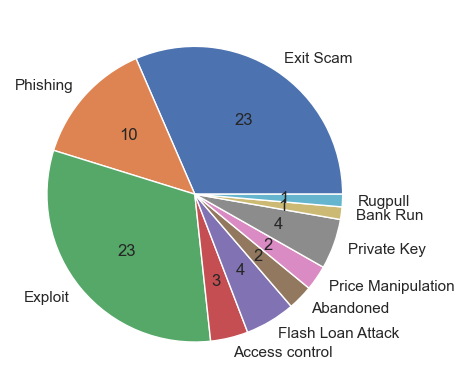

In [97]:
import collections

data = collections.Counter([dat[i] for i in dfData_.iloc[models[0][1]]['File Name'].unique()]) 



def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(data.values(), labels = data.keys(), autopct = autopct_format(data.values()))

### Data Split

In [ ]:

if trainMode == TRAIN_BY_FILES:
    hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY, groups = dfData['Sender ID'])
else:
    hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY)


### Model Training

In [ ]:
skPipeline = Pipeline([('clf', XGBClassifier())])
dPipelineParams = {'clf': [XGBClassifier(), LGBMClassifier()]}

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

### GridSearch and Pipelines combo:


In [ ]:
#skPipeline = Pipeline([('clf', XGBClassifier())])
#dPipelineParams =  {'clf': [XGBClassifier(), LGBMClassifier()]}


skPipeline = Pipeline([("classifier", RandomForestClassifier())])

dPipelineParams = [ {"classifier": [XGBClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__tree_method" : ["hist", "gpu_hist"]
                    },
                    {"classifier": [LGBMClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20]
                                   #"classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    },  
                    {"classifier": [RandomForestClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }                            
                    ]


In [ ]:
##########make sure mX, vY are not redefined into dfs(simply skip K-fold training, using categorical variables (EXPERIMENT) part), naming should be later changed

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
print(gridSearchCvF.best_estimator_.get_params()["classifier"])

In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))